# Tagup Data Engineer Challenge
## Introduction

Hi there! Here, I'll be using this Jupyter notebook as a 'walkthrough' of my though process with coding and working with the data.

First of, I have to import the necessary Python libraries, as well as my preferred ones for data wrangling and visualization.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from sqlalchemy import create_engine, inspect

/Users/Hans/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


## Database
### Exploring

Now I have to load the ExampleCo's database.

In [2]:
# Load database
engine = create_engine('sqlite:///exampleco_db.db', echo = False)

Before extracting the data, I want to explore the company's data and view the overall schema.

In [3]:
# View company table data
engine.table_names()

['feat_0', 'feat_1', 'feat_2', 'feat_3', 'static_data']

It looks like there are five tables.

In [4]:
# Query for table: feat_0
temp_query = "SELECT * FROM feat_0 LIMIT 5;"
conn = engine.execute(temp_query)

In [5]:
# View table columns
conn.keys()

['timestamp', 'machine', 'value']

In [6]:
# View table content head
conn.fetchall()

[('2019-01-01 00:00:00.000000000', 'machine_0', 12.626096305040832),
 ('2019-01-01 08:00:09.603201067', 'machine_0', 10.831994043875898),
 ('2019-01-01 16:00:19.206402134', 'machine_0', 21.08351002126693),
 ('2019-01-02 00:00:28.809603201', 'machine_0', 32.2944947128247),
 ('2019-01-02 08:00:38.412804268', 'machine_0', 28.057099625227075)]

Based on the setup of the table, the 'feat' tables seem to represent the four sensors on each of the companies machines. 

In [7]:
# Checking other feat table contents
temp_query = "SELECT * FROM feat_3 LIMIT 5;"
conn = engine.execute(temp_query)

# View table columns
conn.keys()
# View table content head
conn.fetchall()

[('2019-01-01 00:00:00.000000000', 'machine_0', 10.08396113167012),
 ('2019-01-01 08:00:09.603201067', 'machine_0', 21.89285288708263),
 ('2019-01-01 16:00:19.206402134', 'machine_0', -1.3490236304093648),
 ('2019-01-02 00:00:28.809603201', 'machine_0', -4.250751619890839),
 ('2019-01-02 08:00:38.412804268', 'machine_0', 13.670561149614247)]

Yup! After going through each table, the data looks to be nearly identical, with the exception of the signal values. I should be able to easily create a join statement for the four tables to save space and avoid the repetition with the multiple 'timestamp' and 'machine' columns.

Before I do that I also want to check the static_data column.

In [8]:
static_data_query = "SELECT * FROM static_data;"

conn = engine.execute(static_data_query)
static_data = conn.fetchall()
static_data_attr = engine.execute(static_data_query).keys()

In [9]:
static_data_attr

['machine_id', 'install_date', 'model', 'room']

In [10]:
static_data

[('machine_0', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_1', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_2', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_3', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_4', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_5', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_6', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_7', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_8', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_9', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_10', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_11', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_12', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_13', '2019-01-01', 'Model A', 'Room 123'),
 ('machine_14', '2019-01-01', 'Model B', 'Room 456'),
 ('machine_15', '2019-01-01', 'Model B', 'Room 456'),
 ('machine_16', '2019-01-01', 'Model B', 'Room 456'),
 ('machine_17', '2019-01-01', 'Model B', 'Room 456'),
 ('machine_18', '2019-01-01', 'Model B

I should be able to easily join the contents of this table with everything else, assuming that every 'machine_id' is found on each 'feat' table.

To confirm that I went through each table.

In [11]:
# Checking machine_ids
temp_query = "SELECT machine FROM feat_3 GROUP BY machine;"
engine.execute(temp_query).fetchall()

[('machine_0',),
 ('machine_1',),
 ('machine_10',),
 ('machine_11',),
 ('machine_12',),
 ('machine_13',),
 ('machine_14',),
 ('machine_15',),
 ('machine_16',),
 ('machine_17',),
 ('machine_18',),
 ('machine_19',),
 ('machine_2',),
 ('machine_3',),
 ('machine_4',),
 ('machine_5',),
 ('machine_6',),
 ('machine_7',),
 ('machine_8',),
 ('machine_9',)]

Luckily, each table has the same identifiers—20 machines labeled from 0 to 19.

Overall, the database the client has is relatively clean with no missing values. Merging should not be an issue.

### Joining and Extracting 

After going through the database, I believe that an optimized approach for this problem is by joining all the tables together in a SQL query and perform any necessary cleaning afterwards with Python.

Below, I joined all the tables together by using the 'machine_id' as the unique identifier.

In [12]:
combined_query = """
        SELECT feat_0.timestamp, feat_0.machine,
            feat_0.value AS val0, feat_1.value AS val1,
            feat_2.value as val2, feat_3.value as val3,
            install_date, model, room
        FROM feat_0 
        LEFT JOIN feat_1 
            ON (feat_0.timestamp, feat_0.machine)
                = (feat_1.timestamp, feat_1.machine)
        LEFT JOIN feat_2
            ON (feat_0.timestamp, feat_0.machine)
                = (feat_2.timestamp, feat_2.machine)
        LEFT JOIN feat_3
            ON (feat_0.timestamp, feat_0.machine)
                = (feat_3.timestamp, feat_3.machine)
        LEFT JOIN static_data
            ON feat_0.machine = machine_id;
        """
combined_data = engine.execute(combined_query).fetchall()

In [13]:
# Preview of joined tables
combined_data[0:4]

[('2019-01-01 00:00:00.000000000', 'machine_0', 12.626096305040832, 8.803119792432655, -11.809200175576043, 10.08396113167012, '2019-01-01', 'Model A', 'Room 123'),
 ('2019-01-01 08:00:09.603201067', 'machine_0', 10.831994043875898, 2.816327017562873, 11.554777694964177, 21.89285288708263, '2019-01-01', 'Model A', 'Room 123'),
 ('2019-01-01 16:00:19.206402134', 'machine_0', 21.08351002126693, -0.6726445850209626, -17.839178103236247, -1.3490236304093648, '2019-01-01', 'Model A', 'Room 123'),
 ('2019-01-02 00:00:28.809603201', 'machine_0', 32.2944947128247, 6.525131508232635, -13.498585696204032, -4.250751619890839, '2019-01-01', 'Model A', 'Room 123')]

After going through the original tables and comparing the values with the joint table, everything seems to be in order.

## Summary Statistics

Now that I have extracted the data from the database into a joint list of tuples, I can convert it into a pandas DataFrame. I prefer to do it this way as pandas makes exploring the data and providing summary statistics simple. 

In [14]:
# Creating pandas DataFrame
df = pd.DataFrame(combined_data, 
                  columns = ["time", "machine", "sensor0", "sensor1", "sensor2", 
                             "sensor3", "install_date", "model", "room"])

df.head()

,time,machine,sensor0,sensor1,sensor2,sensor3,install_date,model,room
0,2019-01-01 00:00:00.000000000,machine_0,12.626096,8.803120,-11.809200,10.083961,2019-01-01,Model A,Room 123
1,2019-01-01 08:00:09.603201067,machine_0,10.831994,2.816327,11.554778,21.892853,2019-01-01,Model A,Room 123
2,2019-01-01 16:00:19.206402134,machine_0,21.083510,-0.672645,-17.839178,-1.349024,2019-01-01,Model A,Room 123
3,2019-01-02 00:00:28.809603201,machine_0,32.294495,6.525132,-13.498586,-4.250752,2019-01-01,Model A,Room 123
4,2019-01-02 08:00:38.412804268,machine_0,28.057100,3.691359,21.984744,13.670561,2019-01-01,Model A,Room 123


In [15]:
# Sensor data summary stats
df.describe()

,sensor0,sensor1,sensor2,sensor3
count,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.002310,-0.185737,0.160426,0.294656
std,57.914469,55.542377,56.798872,56.713326
min,-326.441784,-285.538100,-299.880322,-365.362164
25%,-0.010102,-0.010187,-0.010039,-0.010113
50%,0.000065,-0.000154,0.000016,-0.000048
75%,0.010212,0.010003,0.010073,0.010129
max,319.144282,282.440976,297.623913,359.939478


Outliers seem prevelant in all the sensor values. The mean values are close to 0 and the standard deviation is around 50, but the maximum and mininum values are extremely large.

Text(0, 0.5, 'Frequency')

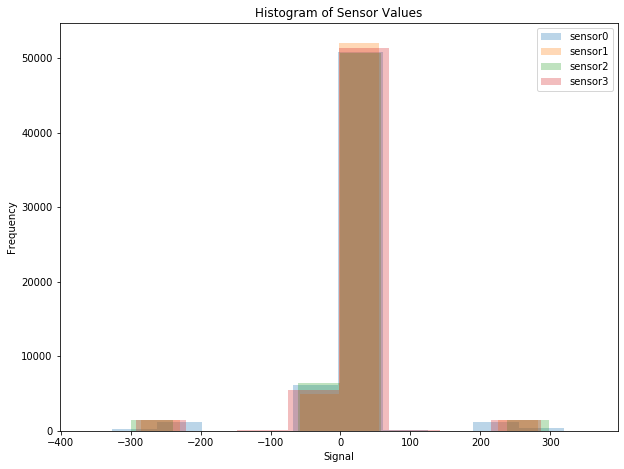

In [26]:
# Visualizations comparing sensor values
plt.figure(figsize = [10, 7.5]);

# Histogram for each sensor
plt.hist(df["sensor0"], alpha = 0.3, label = "sensor0")
plt.hist(df["sensor1"], alpha = 0.3, label = "sensor1")
plt.hist(df["sensor2"], alpha = 0.3, label = "sensor2")
plt.hist(df["sensor3"], alpha = 0.3, label = "sensor3")

# Labels
plt.legend(loc = "upper right")
plt.title("Histogram of Sensor Values")
plt.xlabel("Signal")
plt.ylabel("Frequency")

All the machine sensors seem to be nearly identical, with outliers between -200 to -300 and 200 to 300. It could be beneficial to remove those values, but that could negatively affect the data. I could also replace those values with 0 as a zero value indicates machine failure. A safer approach I could utilize is by using a moving average filter instead. 

In [17]:
# Checking summary stats and histogram for each machine
# df.groupby("machine").describe()
# df.groupby("machine").hist()

I also checked the summary statistics and visualizations for each machine with the code above. I commented them out as running the code took up a lot of space.

Curiously, I wanted to see time series visualizations for the machines.

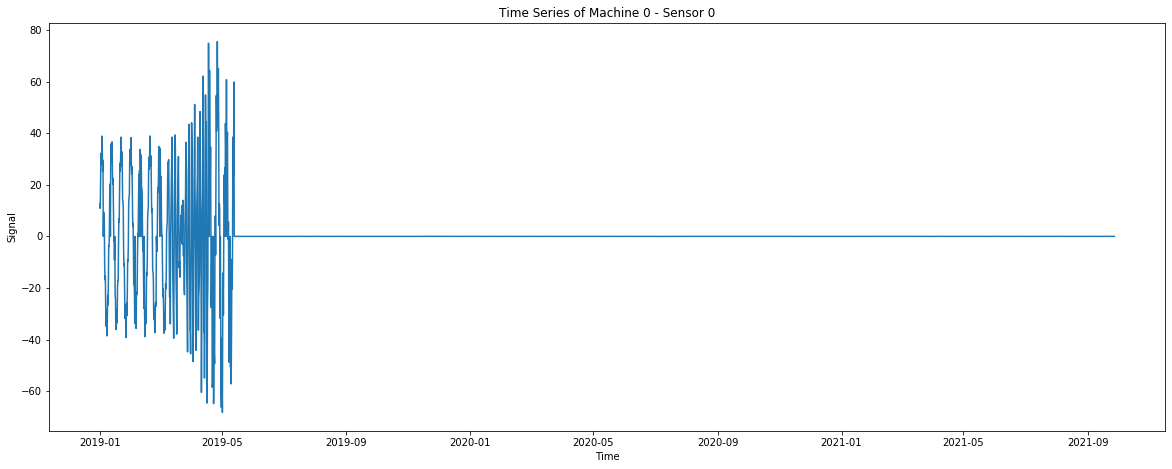

In [94]:
# Filter by machine_0 only
machine_0 = df[df["machine"] == "machine_0"]

# Visualize
plt.figure(figsize = [20, 7.5])
plt.title("Time Series of Machine 0 - Sensor 0")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.plot(machine_0["time"].to_numpy(), machine_0["sensor0"].to_numpy())

The outliers do seem to really mess up the data.

## Cleaning
Here, I'll be cleaning the data in multiple ways.

### Rounding Time

One thing I've noticed is that the machine sensors seem to be automated and record signals every eight hours. However, the times are all different which may make future analysis and visualizations harder. For example, plotting a time series may be difficult due to the various axes-consistent times will help make the visualization process go smoother. A way to fix this is by rounding the times to the nearest hour like so:

In [30]:
# Cleaning time by rounding to nearest hour
df["time"] = pd.to_datetime(df["time"])
df["time"] = df["time"].dt.round("H")
df.head()

,time,machine,sensor0,sensor1,sensor2,sensor3,install_date,model,room
0,2019-01-01 00:00:00,machine_0,12.626096,8.803120,-11.809200,10.083961,2019-01-01,Model A,Room 123
1,2019-01-01 08:00:00,machine_0,10.831994,2.816327,11.554778,21.892853,2019-01-01,Model A,Room 123
2,2019-01-01 16:00:00,machine_0,21.083510,-0.672645,-17.839178,-1.349024,2019-01-01,Model A,Room 123
3,2019-01-02 00:00:00,machine_0,32.294495,6.525132,-13.498586,-4.250752,2019-01-01,Model A,Room 123
4,2019-01-02 08:00:00,machine_0,28.057100,3.691359,21.984744,13.670561,2019-01-01,Model A,Room 123


### Adding 0's to First Ten Machines

A minor thing I've also noticed is that the way the machine_ids are labeled will make sorting them incorrect. Due to the nature of how strings work, this is a problem as the machine names will be in lexicographic order. For example, if the machines are sorted they would be in this order: 'machine_0', 'machine_1', 'machine_10', 'machine_11', ... 'machine_19', 'machine_2' and so on.

A way to fix this would be to simply add a 0 in front of the first ten digits.

In [31]:
# Add a zero in front of first ten digits
first_ten_machines = df["machine"].unique()[0:10]

# Add zero in front of first ten digits
for name in first_ten_machines:
    curr_num = name[len(name) - 1]    
    df["machine"] = df["machine"].replace([name], "machine_0" + curr_num)

In [32]:
df["machine"].unique()

array(['machine_00', 'machine_01', 'machine_02', 'machine_03',
       'machine_04', 'machine_05', 'machine_06', 'machine_07',
       'machine_08', 'machine_09', 'machine_10', 'machine_11',
       'machine_12', 'machine_13', 'machine_14', 'machine_15',
       'machine_16', 'machine_17', 'machine_18', 'machine_19'],
      dtype=object)

### Fixing Sensor Outliers

From earlier visualizations, I saw that there were many outliers for the sensor values. I will replace values greater than 150 and less than -150 with 0 (to indicate machine failure).  

In [33]:
sensors = ["sensor0", "sensor1", "sensor2", "sensor3"]

# Replace numbers greater than 150 or less than 150 with 0
for sensor in sensors:
    condition = (df[sensor] < 150) & (df[sensor] > -150)
    df[sensor].where(condition, 0, inplace = True)

Let's see how replace the values does with the visualization:

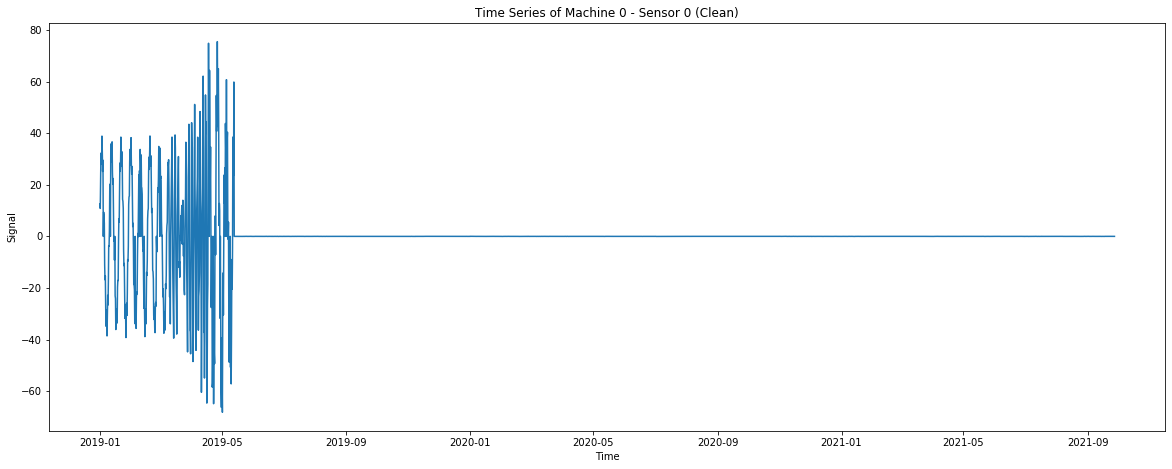

In [95]:
# Filter by machine_0 only
machine_0 = df[df["machine"] == "machine_00"]

plt.figure(figsize = [20, 7.5])
plt.title("Time Series of Machine 0 - Sensor 0 (Clean)")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.plot(machine_0["time"].to_numpy(), machine_0["sensor0"].to_numpy())

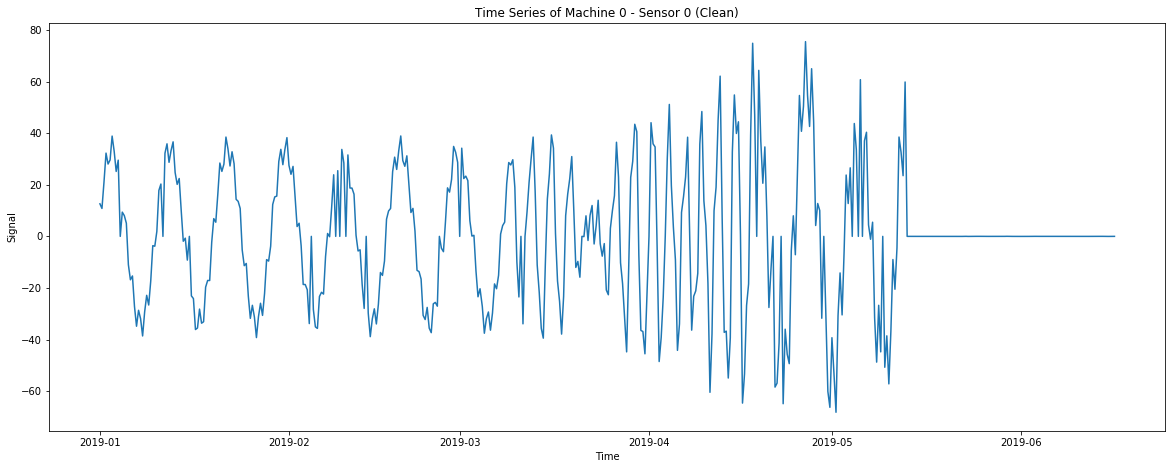

In [96]:
# Plot of earlier dates
plt.figure(figsize = [20, 7.5])
plt.title("Time Series of Machine 0 - Sensor 0 (Clean)")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.plot(machine_0[0:500]["time"].to_numpy(), machine_0[0:500]["sensor0"].to_numpy())

And compared to the original, the new ones seem to look a lot better!

## Loading as xarray Dataset (Multiple DataArrays)

Now that the data is clean, I can load it as multidimensional arrays for the data science team to use. As the team uses the xarray library, I wanted to learn more about it and ensure that they are recieving data they are comfortable reading in and working with.

In my head it makes sense to make a 20 DataArrays consisting of each of ExampleCo's machines. For each element, it will contain machine attributes or labels from 'static_data' (such as room, installation date, and other relevant information), as well as all the four sensor values and corresponding time they were recorded. The DataArrays can be combined to form an xarray Dataset. All in all there is 20 arrays with each element having the corresponding machine's sensor values and time recorded.

In [117]:
# Creating individual arrays and appending them together into a list
data_arrays = []

# Goes through each machine (machine_00 -> machine_19)
for m in df["machine"].unique():
    filtered_machine = df[df["machine"] == m]
    
    new_arr = xr.DataArray(
        data = filtered_machine[["sensor0", "sensor1", 
                                 "sensor2", "sensor3"]],
        dims = ["time", "sensor"],
        coords = dict(
            time = df["time"].unique(),
            sensor_labels = (["time", "sensor"], 
                             [["sensor0", "sensor1", 
                               "sensor2", "sensor3"]] * len(df["time"].unique())
                            )
        ),
        attrs = dict(
            company = "ExampleCo, Inc",
            machine = m,
            model = filtered_machine["model"].tolist()[0],
            install_date = filtered_machine["install_date"].tolist()[0],
            room = filtered_machine["room"].tolist()[0]
        ),
        name = m
    )
    
    data_arrays.append(new_arr)

In [119]:
# Combine arrays into an xarray Dataset
combined_dataset = xr.combine_by_coords(data_arrays)
combined_dataset

<xarray.Dataset>
Dimensions:        (time: 3000, sensor: 4)
Coordinates:
  * time           (time) datetime64[ns] 2019-01-01 ... 2021-09-27
    sensor_labels  (time, sensor) <U7 'sensor0' 'sensor1' ... 'sensor3'
Dimensions without coordinates: sensor
Data variables: (12/20)
    machine_00     (time, sensor) float64 12.63 8.803 -11.81 ... 0.01246 0.014
    machine_01     (time, sensor) float64 12.59 8.83 -11.8 ... -0.01938 0.01489
    machine_02     (time, sensor) float64 12.61 8.824 ... 0.007998 0.009459
    machine_03     (time, sensor) float64 12.6 8.836 ... -0.002466 0.007762
    machine_04     (time, sensor) float64 -32.45 -2.766 ... -0.02547 0.008511
    machine_05     (time, sensor) float64 12.6 8.837 ... -0.005171 -0.00277
    ...             ...
    machine_14     (time, sensor) float64 12.63 0.0 -11.79 ... -0.006003 0.01111
    machine_15     (time, sensor) float64 12.61 8.817 ... 0.005023 0.002082
    machine_16     (time, sensor) float64 12.62 8.82 ... 0.009061 0.008156
    machine_17     (time, sensor) float64 12.6 8.81 ... -0.004162 -0.007063
    machine_18     (time, sensor) float64 12.61 8.823 ... -0.001231 0.003975
    machine_19     (time, sensor) float64 26.24 8.144 -16.31 ... 0.0 0.01233

To test the efficiency of my data structure I'll utilize various the xarray API methods.

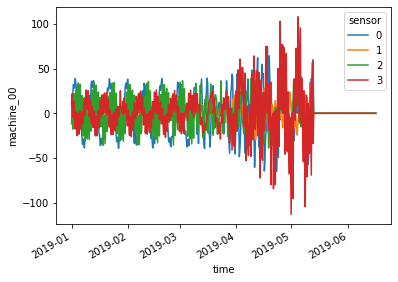

In [129]:
# Testing plotting functionality
combined_dataset["machine_00"][0:500].plot.line(x = "time")

In [136]:
# Getting data for first index or time for each machine
combined_dataset.isel(time = 0)

<xarray.Dataset>
Dimensions:        (sensor: 4)
Coordinates:
    time           datetime64[ns] 2019-01-01
    sensor_labels  (sensor) <U7 'sensor0' 'sensor1' 'sensor2' 'sensor3'
Dimensions without coordinates: sensor
Data variables: (12/20)
    machine_00     (sensor) float64 12.63 8.803 -11.81 10.08
    machine_01     (sensor) float64 12.59 8.83 -11.8 10.08
    machine_02     (sensor) float64 12.61 8.824 -11.81 10.08
    machine_03     (sensor) float64 12.6 8.836 -11.79 10.08
    machine_04     (sensor) float64 -32.45 -2.766 0.0 0.0
    machine_05     (sensor) float64 12.6 8.837 -11.8 10.09
    ...             ...
    machine_14     (sensor) float64 12.63 0.0 -11.79 10.07
    machine_15     (sensor) float64 12.61 8.817 -11.79 10.08
    machine_16     (sensor) float64 12.62 8.82 -11.81 10.07
    machine_17     (sensor) float64 12.6 8.81 -11.81 10.08
    machine_18     (sensor) float64 12.61 8.823 -11.79 10.09
    machine_19     (sensor) float64 26.24 8.144 -16.31 -2.647

In [139]:
# Getting data for for beginning time and machine 19
combined_dataset.isel(time = 0)["machine_19"]

<xarray.DataArray 'machine_19' (sensor: 4)>
array([ 26.23583558,   8.14373104, -16.31363296,  -2.6470036 ])
Coordinates:
    time           datetime64[ns] 2019-01-01
    sensor_labels  (sensor) <U7 'sensor0' 'sensor1' 'sensor2' 'sensor3'
Dimensions without coordinates: sensor
Attributes:
    company:       ExampleCo, Inc
    machine:       machine_19
    model:         Model B
    install_date:  2019-01-01
    room:          Room 456

With everything looking okay, I can write the Dataset out and upload it to AWS S3 via netCDF format. I can do that by simply calling the following method:

In [140]:
# Writing to disk
combined_dataset.to_netcdf("exampleco_data.nc")

And that should be it! Thank you for letting me partake in the Tagup data engineering challenge and for going through my though process.